# Solving Regression Challenge

### The Scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

Then let's **examine the dataset** using the `info()` and check for missing values

In [2]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [3]:
#look for display
houseprices_df.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Show me columns with **missing values**

In [4]:
houseprices_df.columns[houseprices_df.isna().any()].tolist()

['lotfrontage',
 'alley',
 'masvnrtype',
 'masvnrarea',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'electrical',
 'fireplacequ',
 'garagetype',
 'garageyrblt',
 'garagefinish',
 'garagequal',
 'garagecond',
 'poolqc',
 'fence',
 'miscfeature']

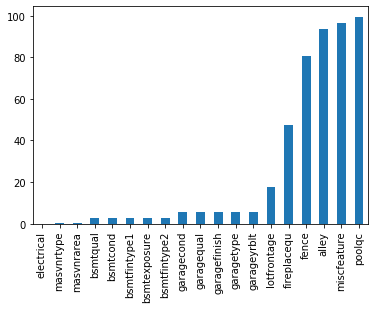

In [5]:
missing = houseprices_df.isnull().sum()*100/houseprices_df.isnull().count()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

This graph shows 19 columns has missing values where five of which has more than 20% missing data. And they are *fireplacequ, fence, alley, miscfeature and poolqc*.

In [6]:
for column_name in houseprices_df.columns:
    print("Unique values in column {} are: {}".format(column_name, houseprices_df[column_name].unique()))

Unique values in column id are: [   1    2    3 ... 1458 1459 1460]
Unique values in column mssubclass are: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Unique values in column mszoning are: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Unique values in column lotfrontage are: [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
Unique values in column lotarea are: [ 8450  9600 11250 ... 17217 13175  9717]
Unique values in column street are: ['Pave' 'Grvl']
Unique values in column 

**Categorical Values**
 'alley', 'masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',  'bsmtfintype2', 'electrical', 'fireplacequ', 'garagetype',  'garagefinish', 'garagequal', 'garagecond', 'poolqc',  'fence',  'miscfeature'
 
**Continuous Values**
 'lotfrontage', 'masvnrarea', 'garageyrblt'
 
 What do we do with this missing information?
 Since most of them are categorical values we can continue with our model.

---
#### TARGET variable and FEATURE sets

In [7]:
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)

In [8]:
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

houseprices_df['int_over_sf'] = houseprices_df['totalsf'] * houseprices_df['overallqual']

# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 
                    'totalbsmtsf'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Thu, 17 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:45:48   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  2.509e+04   1.37e+04      1.833      0.067   -1761.679    5.19e+04
mszoning_RH  1.342e+04   1.58e+04      0.847      0.397   -1.77e+04    4.45e+04
mszoning_RL  2.857e+04   1.27e+04      2.246      0.025    3612.782    5.35e+04
mszoning_RM  9047.7894   1.29e+04      0.702      0.483   -1.62e+04    3.43e+04
street_Pave   151.0376   1.63e+04      0.009      0.993   -3.18e+04    3.21e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     5.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Splitting the Data
Split the data into train and test sets where 20% of the data resides in the test set.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


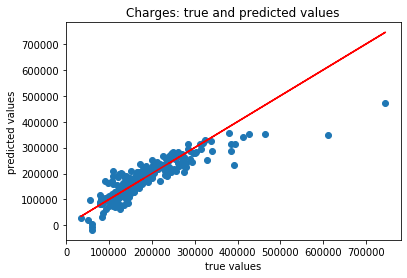

Mean absolute error of the prediction is: 25213.046477035274
Mean squared error of the prediction is: 1511758306.2432895
Root mean squared error of the prediction is: 38881.336219879195
Mean absolute percentage error of the prediction is: 15.356973087725839


In [10]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}"
      .format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Linear Regression Models

Build several linear regression models including *Lasso, Ridge, or ElasticNet* and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [11]:
from sklearn.linear_model import LinearRegression

Y = houseprices_df['saleprice']

numerical_cols = [col_name for col_name in houseprices_df.dtypes
                  [houseprices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["id", "saleprice"] ]

X = houseprices_df[numerical_cols]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")



The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.9585789333491452
-----Test set statistics-----


In [12]:
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the test set is: -8.322113503189305e+19
Mean absolute error of the prediction is: 76222002675491.28
Mean squared error of the prediction is: 5.587220737287402e+29
Root mean squared error of the prediction is: 747477139268312.5
Mean absolute percentage error of the prediction is: 32297014874.831223


In [13]:
from sklearn.linear_model import LinearRegression

# This is the model with linear feature
lrm_underfit = LinearRegression().fit(X, Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with quadratic feature
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to 10th order polynomial of the feature
X_overfit = pd.concat([X**i for i in range(1,11)], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

**Ridge**

In [14]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7763836048513303
-----Test set statistics-----
R-squared of the model on the test set is: 0.556811576626076
Mean absolute error of the prediction is: 39478.713664267125
Mean squared error of the prediction is: 2975435925.8036304
Root mean squared error of the prediction is: 54547.55655209159
Mean absolute percentage error of the prediction is: 23.253924404129716


**Lasso**

In [15]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7892828372145917
-----Test set statistics-----
R-squared of the model on the test set is: 0.6365691481213215
Mean absolute error of the prediction is: 35620.048454238124
Mean squared error of the prediction is: 2439967192.7190127
Root mean squared error of the prediction is: 49396.02405780259
Mean absolute percentage error of the prediction is: 21.10844745119078


**ElasticNet**

In [21]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format
      (elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7586573851497739
-----Test set statistics-----
R-squared of the model on the test set is: 0.5779924489027854
Mean absolute error of the prediction is: 37300.0811696221
Mean squared error of the prediction is: 2833233817.2011533
Root mean squared error of the prediction is: 53228.129942739426
Mean absolute percentage error of the prediction is: 22.021555209382065


### Which Model?

When we compare the training set and the test set between the three model. Lasso's Model wins by far. It has the closed value between traning and test set and it also has the lease about of error of predictions. Lasso is the most accurate between the three.

### k-fold cross-validation 

In [23]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e+38
R-squared of the model in training set is: 0.7366309413908065
-----Test set statistics-----
R-squared of the model in test set is: 0.513810005024891
Mean absolute error of the prediction is: 40859.49285219529
Mean squared error of the prediction is: 3264135752.469074
Root mean squared error of the prediction is: 57132.61548773234
Mean absolute percentage error of the prediction is: 23.876311365629782


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format
      (rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e+22
R-squared of the model in training set is: 0.5239505525932345
-----Test set statistics-----
R-squared of the model in test set is: 0.48811890996579743
Mean absolute error of the prediction is: 39720.8474872007
Mean squared error of the prediction is: 3436618162.163173
Root mean squared error of the prediction is: 58622.676177083325
Mean absolute percentage error of the prediction is: 24.48763983602568


In [19]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format
      (elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e+22
R-squared of the model in training set is: 0.6230298452939758
-----Test set statistics-----
R-squared of the model in test set is: 0.5385610942741836
Mean absolute error of the prediction is: 36826.55798275163
Mean squared error of the prediction is: 3097964263.6145883
Root mean squared error of the prediction is: 55659.35917358902
Mean absolute percentage error of the prediction is: 22.55997613088247


### Evaluation Time

Evaluate your best model on the test set.

When we do the k-fold cross validation in our data all of the model has noticebly improved. LassoCV still has the closes value between test and traning, followed by ElasticNetCV then lastly RidgeCV. LassoCV's error of predition od 24 is higher compared to the rest of the model.

### Summary
So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model

As they say in buying a house, LOCATION LOCATION LOCATION. Location is important in buying a house. When your house is built near a school, you will have melarose tax that you need to factor in. Another factor is the crime rate in the area. If the house is built using the best material, best technology that money could buy, you may get a good deal if the crime rate is high. If your house is in a cliff and your in California, earthquate is something we need to factor in. What natural disaster the area may have? The better the weather the higher the cost. 